##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 回帰：燃費を予測する 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Note: これらのドキュメントは私たちTensorFlowコミュニティが翻訳したものです。コミュニティによる 翻訳は**ベストエフォート**であるため、この翻訳が正確であることや[英語の公式ドキュメント](https://www.tensorflow.org/?hl=en)の 最新の状態を反映したものであることを保証することはできません。 この翻訳の品質を向上させるためのご意見をお持ちの方は、GitHubリポジトリ[tensorflow/docs](https://github.com/tensorflow/docs)にプルリクエストをお送りください。 コミュニティによる翻訳やレビューに参加していただける方は、 [docs-ja@tensorflow.org メーリングリスト](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ja)にご連絡ください。

回帰問題では、価格や確率といった連続的な値の出力を予測することが目的となります。これは、分類問題の目的が、（たとえば、写真にリンゴが写っているかオレンジが写っているかといった）離散的なラベルを予測することであるのとは対照的です。

このノートブックでは、古典的な[Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg)データセットを使用し、1970年代後半から1980年台初めの自動車の燃費を予測するモデルを構築します。この目的のため、モデルにはこの時期の多数の自動車の仕様を読み込ませます。仕様には、気筒数、排気量、馬力、重量などが含まれています。

このサンプルでは`tf.keras` APIを使用しています。詳細は[このガイド](https://www.tensorflow.org/guide/keras)を参照してください。

In [3]:
# ペアプロットのためseabornを使用します
!pip install -q seaborn

In [4]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


## Auto MPG データセット

このデータセットは[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/)から入手可能です。

### データの取得

まず、データセットをダウンロードします。

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

 8192/30286 [=======>......................] - ETA: 0s

32768/30286 [================================] - 0s 4us/step


'/home/kbuilder/.keras/datasets/auto-mpg.data'

pandasを使ってデータをインポートします。

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### データのクレンジング

このデータには、いくつか欠損値があります。

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

この最初のチュートリアルでは簡単化のためこれらの行を削除します。

In [8]:
dataset = dataset.dropna()

`"Origin"`の列は数値ではなくカテゴリーです。このため、ワンホットエンコーディングを行います。

In [9]:
origin = dataset.pop('Origin')

In [10]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### データを訓練用セットとテスト用セットに分割

データセットを訓練用セットとテスト用セットに分割しましょう。

テスト用データセットは、作成したモデルの最終評価に使用します。

In [11]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### データの観察

訓練用セットのいくつかの列の組み合わせの同時分布を見てみましょう。

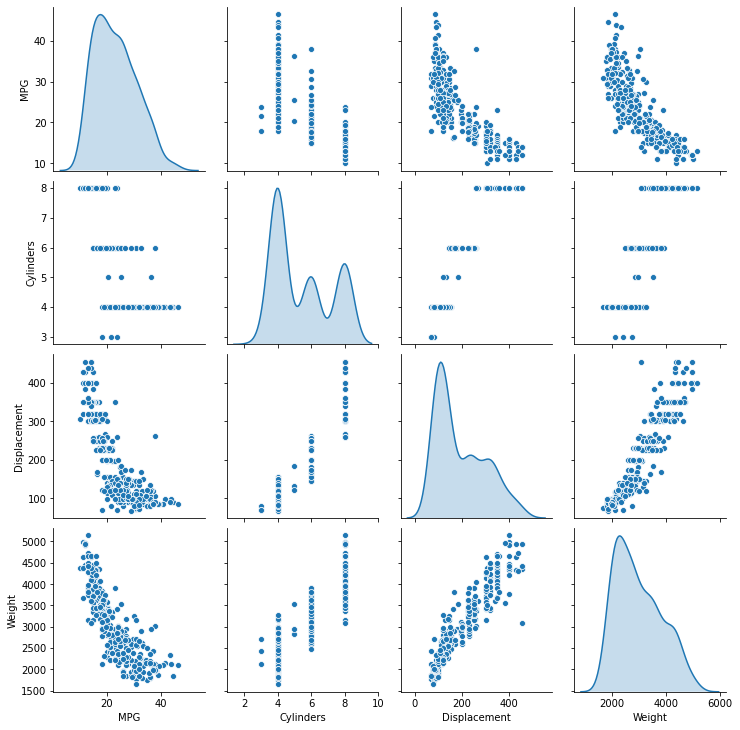

In [12]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

全体の統計値も見てみましょう。

In [13]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### ラベルと特徴量の分離

ラベル、すなわち目的変数を特徴量から切り離しましょう。このラベルは、モデルに予測させたい数量です。

In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### データの正規化

上の`train_stats`のブロックをもう一度見て、それぞれの特徴量の範囲がどれほど違っているかに注目してください。

スケールや値の範囲が異なる特徴量を正規化するのはよい習慣です。特徴量の正規化なしでもモデルは収束する**かもしれませんが**、モデルの訓練はより難しくなり、結果として得られたモデルも入力で使われる単位に依存することになります。

注：（正規化に使用する）統計量は意図的に訓練用データセットだけを使って算出していますが、これらはテスト用データセットの正規化にも使うことになります。テスト用のデータセットを、モデルの訓練に使用した分布とおなじ分布に射影する必要があるのです。

In [15]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

この正規化したデータを使ってモデルを訓練することになります。

注意：ここで入力の正規化に使った統計量（平均と標準偏差）は、さきほど実施したワンホットエンコーディングとともに、モデルに供給するほかのどんなデータにも適用する必要があります。テスト用データセットだけでなく、モデルをプロダクション環境で使用する際の生のデータについても同様です。

## モデル

### モデルの構築

それではモデルを構築しましょう。ここでは、2つの全結合の隠れ層と、1つの連続値を返す出力層からなる、`Sequential`モデルを使います。モデルを構築するステップは`build_model`という1つの関数の中に組み込みます。あとから2つ目のモデルを構築するためです。

In [16]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [17]:
model = build_model()

### モデルの検証

`.summary`メソッドを使って、モデルの簡単な説明を表示します。

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


では、モデルを試してみましょう。訓練用データのうち`10`個のサンプルからなるバッチを取り出し、それを使って`model.predict`メソッドを呼び出します。

In [19]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.4559034 ],
       [-0.16621543],
       [ 0.14248657],
       [-0.3970424 ],
       [-0.24298441],
       [-0.07454799],
       [-0.25038257],
       [-0.15623756],
       [-0.09587125],
       [-0.2829889 ]], dtype=float32)

うまく動作しているようです。予定どおりの型と形状の出力が得られています。

### モデルの訓練

モデルを1000エポック訓練し、訓練と検証の正解率を`history`オブジェクトに記録します。

In [20]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

..
.....

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

....
...

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

......
.

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.
......

.......

.......

.......

.......

.......

.......

.......

.......

......

......

......

......

.......

.......


.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

..
.....

.......

.......

......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.....
..

.......

.......

.......

.......

.......

.......

......

.......

.......

.......

.......

.......

.......

.......

.
......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

...
....

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.......

.....

`history`オブジェクトに保存された数値を使ってモデルの訓練の様子を可視化します。

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,3.165757,1.105017,3.165757,8.376025,2.132884,8.376025,995
996,3.187268,1.171486,3.187268,7.988904,2.072100,7.988904,996
997,3.032976,1.108827,3.032976,7.843792,2.069101,7.843792,997
998,3.121359,1.093149,3.121359,8.359231,2.159137,8.359231,998
999,2.972336,1.105997,2.972336,8.154050,2.141978,8.154050,999


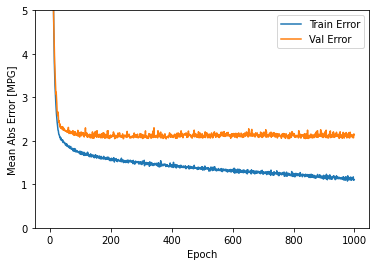

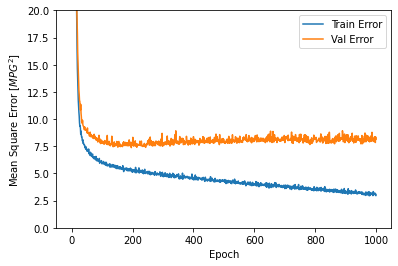

In [22]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

このグラフを見ると、検証エラーは100エポックを過ぎたあたりで改善が見られなくなり、むしろ悪化しているようです。検証スコアの改善が見られなくなったら自動的に訓練を停止するように、`model.fit`メソッド呼び出しを変更します。ここでは、エポック毎に訓練状態をチェックする*EarlyStopping*コールバックを使用します。設定したエポック数の間に改善が見られない場合、訓練を自動的に停止します。

このコールバックについての詳細は[ここ](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)を参照ください。


.......

.......

.......

.......

.......

.......

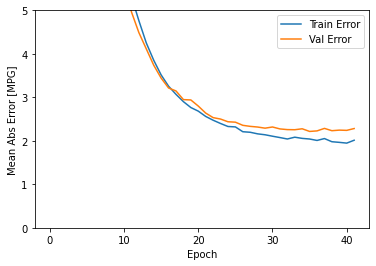

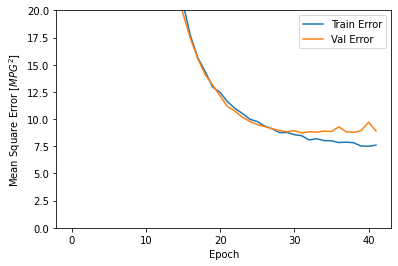

In [23]:
model = build_model()

# patience は改善が見られるかを監視するエポック数を表すパラメーター
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

検証用データセットでのグラフを見ると、平均誤差は+/- 2 MPG（マイル/ガロン）前後です。これはよい精度でしょうか？その判断はおまかせします。

モデルの訓練に使用していない**テスト用**データセットを使って、モデルがどれくらい汎化できているか見てみましょう。これによって、モデルが実際の現場でどれくらい正確に予測できるかがわかります。

In [24]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.7989 - mae: 1.9424 - mse: 6.7989


Testing set Mean Abs Error:  1.94 MPG


### モデルを使った予測

最後に、テストデータを使ってMPG値を予測します。

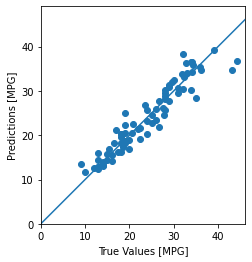

In [25]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


そこそこよい予測ができているように見えます。誤差の分布を見てみましょう。

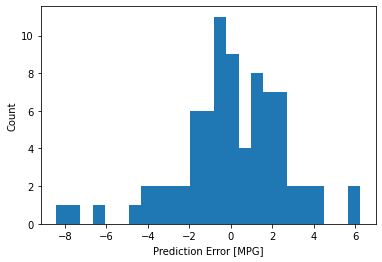

In [26]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

とても正規分布には見えませんが、サンプル数が非常に小さいからだと考えられます。

## 結論

このノートブックでは、回帰問題を扱うためのテクニックをいくつか紹介しました。

* 平均二乗誤差（MSE: Mean Squared Error）は回帰問題に使われる一般的な損失関数です（分類問題には異なる損失関数が使われます）。
* 同様に、回帰問題に使われる評価指標も分類問題とは異なります。回帰問題の一般的な評価指標は平均絶対誤差（MAE: Mean Absolute Error）です。
* 入力数値特徴量の範囲が異なっている場合、特徴量ごとにおなじ範囲に正規化するべきです。
* 訓練用データが多くない場合、過学習を避けるために少ない隠れ層をもつ小さいネットワークを使うというのがよい方策の1つです。
* Early Stoppingは過学習を防止するための便利な手法の一つです。